### Uczenie maszynowe
# 10. Przegląd metod uczenia nadzorowanego – część 2

In [1]:
# Przydatne importy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas

%matplotlib inline

## 10.1. Maszyny wektorów nośnych

In [96]:
# Wczytanie danych (gatunki kosaćców)

data_iris = pandas.read_csv('iris.csv')
data_iris_setosa = pandas.DataFrame()
data_iris_setosa['dł. płatka'] = data_iris['pl']  # "pl" oznacza "petal length"
data_iris_setosa['szer. płatka'] = data_iris['pw']  # "pw" oznacza "petal width"

# SVM to metoda klasyfikacji dwuklasowej.
# Poszczególne klasy będziemy oznaczać jako "1" i "-1":
data_iris_setosa['Iris setosa?'] = data_iris['Gatunek'].apply(lambda x: 1 if x=='Iris-setosa' else -1)

m, n_plus_1 = data_iris_setosa.values.shape
n = n_plus_1 - 1
X = data_iris_setosa.values[:, 0:n].reshape(m, n)
Y = np.array(data_iris_setosa.values[:, 2])

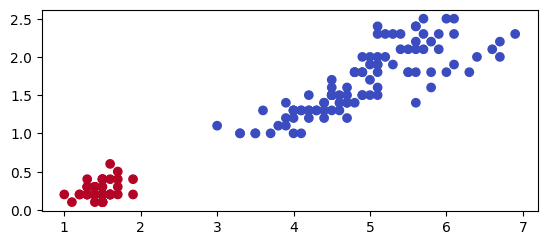

In [149]:
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm')
ax.set_aspect('equal')

In [100]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, Y)

SVC(C=10000000000.0, kernel='linear')

In [157]:
def plot_svc_decision_function(model, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors=['orange', 'green', 'orange'],
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='purple', facecolors='none')
    ax.set_aspect('equal')

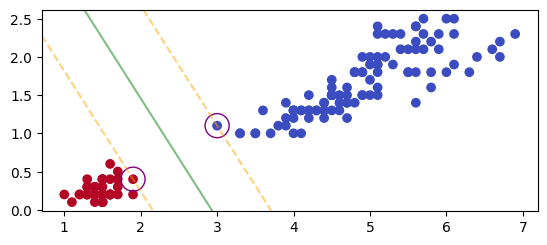

In [158]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm')
plot_svc_decision_function(model)

**Maszyna wektorów nośnych** (*support vector machine*) próbuje oddzielić punkty należące do różnych klas <small>(<span style="color:red">czerwone</span> i <span style="color:blue">niebieskie</span> kropki)</small> za pomocą <span style="color:green">**hiperpłaszczyzny** <small>(zielona ciągła linia)</small></span> w taki sposób, żeby <span style="color:orange">**margines** <small>(obszar między pomarańczowymi przerywanymi liniami)</small></span> był jak największy.

Punkty, które stykają się z marginesem, nazywamy <span style="color:purple">**wektorami nośnymi** <small>(fioletowe kółka)</small></span> – stąd nazwa metody.

W celu znalezienia hiperpłaszczyzny wykorzystywana jest funkcja kosztu *hinge loss*:
$$ J(y) = \max(0, 1 - t \cdot y) , $$
gdzie $t$ to oczekiwana wartość klasyfikacji ($1$ lub $-1$), a $y$ to wyjście klasyfikatora.

 W przypadku *liniowej* maszyny wektorów nośnych:
 $$ y = w \cdot x + b , $$
 gdzie $w$ i $b$ to parametry hiperpłaszczyzny, a $x$ to wejście klasyfikatora (wektor cech).

Nauczenie klasyfikatora SVM sprowadza się do znalezienia parametrów hiperpłaszczyzny, która minimalizuje funkcję kosztu. Można to zrobić np. za pomocą metody spadku gradientu.

Jeżeli klas nie da się oddzielić za pomocą hiperpłaszczyzny, można przekształcić dane wejściowe za pomocą odpowiedniej funkcji (tzw. *kernel trick*) tak, aby przekształcone dane były oddzielalne.

## 10.2. Drzewa decyzyjne

### Drzewa decyzyjne – przykład

In [64]:
alldata = pandas.read_csv('tennis.tsv', sep='\t')
print(alldata)

    Day   Outlook Humidity    Wind Play
0     1     Sunny     High    Weak   No
1     2     Sunny     High  Strong   No
2     3  Overcast     High    Weak  Yes
3     4      Rain     High    Weak  Yes
4     5      Rain   Normal    Weak  Yes
5     6      Rain   Normal  Strong   No
6     7  Overcast   Normal  Strong  Yes
7     8     Sunny     High    Weak   No
8     9     Sunny   Normal    Weak  Yes
9    10      Rain   Normal    Weak  Yes
10   11     Sunny   Normal  Strong  Yes
11   12  Overcast     High  Strong  Yes
12   13  Overcast   Normal    Weak  Yes
13   14      Rain     High  Strong   No


In [65]:
# Dane jako lista słowników
data = alldata.T.to_dict().values()
features = ['Outlook', 'Humidity', 'Wind']

# Możliwe wartości w poszczególnych kolumnach
values = {feature: set(row[feature] for row in data)
          for feature in features}
values

{'Outlook': {'Overcast', 'Rain', 'Sunny'},
 'Humidity': {'High', 'Normal'},
 'Wind': {'Strong', 'Weak'}}

* Czy John zagra w tenisa, jeżeli będzie padać, przy wysokiej wilgotności i silnym wietrze?
* Algorytm drzew decyzyjnych spróbuje _zrozumieć_ „taktykę” Johna.
* Wykorzystamy metodę „dziel i zwyciężaj”.

In [66]:
# Podziel dane
def split(features, data):
    values = {feature: list(set(row[feature]
                                for row in data))
              for feature in features}
    if not features:
        return data
    return {val: split(features[1:],
                       [row for row in data
                        if row[features[0]] == val])
            for val in values[features[0]]}

In [67]:
split_data = split(['Outlook'], data)

for outlook in values['Outlook']:
    print('\n\tOutlook\tHumid\tWind\tPlay')
    for row in split_data[outlook]:
        print('Day {Day}:\t{Outlook}\t{Humidity}\t{Wind}\t{Play}'
              .format(**row))


	Outlook	Humid	Wind	Play
Day 1:	Sunny	High	Weak	No
Day 2:	Sunny	High	Strong	No
Day 8:	Sunny	High	Weak	No
Day 9:	Sunny	Normal	Weak	Yes
Day 11:	Sunny	Normal	Strong	Yes

	Outlook	Humid	Wind	Play
Day 4:	Rain	High	Weak	Yes
Day 5:	Rain	Normal	Weak	Yes
Day 6:	Rain	Normal	Strong	No
Day 10:	Rain	Normal	Weak	Yes
Day 14:	Rain	High	Strong	No

	Outlook	Humid	Wind	Play
Day 3:	Overcast	High	Weak	Yes
Day 7:	Overcast	Normal	Strong	Yes
Day 12:	Overcast	High	Strong	Yes
Day 13:	Overcast	Normal	Weak	Yes


Obserwacja: John lubi grać, gdy jest pochmurnie.

W pozostałych przypadkach podzielmy dane ponownie:

In [68]:
split_data_sunny = split(['Outlook', 'Humidity'], data)

for humidity in values['Humidity']:
    print('\n\tOutlook\tHumid\tWind\tPlay')
    for row in split_data_sunny['Sunny'][humidity]:
        print('Day {Day}:\t{Outlook}\t{Humidity}\t{Wind}\t{Play}'
              .format(**row))


	Outlook	Humid	Wind	Play
Day 1:	Sunny	High	Weak	No
Day 2:	Sunny	High	Strong	No
Day 8:	Sunny	High	Weak	No

	Outlook	Humid	Wind	Play
Day 9:	Sunny	Normal	Weak	Yes
Day 11:	Sunny	Normal	Strong	Yes


In [69]:
split_data_rain = split(['Outlook', 'Wind'], data)

for wind in values['Wind']:
    print('\n\tOutlook\tHumid\tWind\tPlay')
    for row in split_data_rain['Rain'][wind]:
        print('Day {Day}:\t{Outlook}\t{Humidity}\t{Wind}\t{Play}'
              .format(**row))


	Outlook	Humid	Wind	Play
Day 6:	Rain	Normal	Strong	No
Day 14:	Rain	High	Strong	No

	Outlook	Humid	Wind	Play
Day 4:	Rain	High	Weak	Yes
Day 5:	Rain	Normal	Weak	Yes
Day 10:	Rain	Normal	Weak	Yes


* Outlook=
  * Overcast
    * → Playing
  * Sunny
    * Humidity=
      * High
        * → Not playing
      * Normal
        * → Playing
  * Rain
    * Wind=
      * Weak
        * → Playing
      * Strong
        * → Not playing

* (9/5)
  * Outlook=Overcast (4/0)
    * YES
  * Outlook=Sunny (2/3)
    * Humidity=High (0/3)
      * NO
    * Humidity=Normal (2/0)
      * YES
  * Outlook=Rain (3/2)
    * Wind=Weak (3/0)
      * YES
    * Wind=Strong (0/2)
      * NO

### Algorytm ID3

Pseudokod algorytmu:

* podziel(węzeł, zbiór przykładów):
    1. A ← najlepszy atrybut do podziału zbioru przykładów
    1. Dla każdej wartości atrybutu A, utwórz nowy węzeł potomny
    1. Podziel zbiór przykładów na podzbiory według węzłów potomnych
    1. Dla każdego węzła potomnego i podzbioru:
        * jeżeli podzbiór jest jednolity: zakończ
        * w przeciwnym przypadku: podziel(węzeł potomny, podzbiór)

Jak wybrać „najlepszy atrybut”?
* powinien zawierać jednolity podzbiór
* albo przynajmniej „w miarę jednolity”

Skąd wziąć miarę „jednolitości” podzbioru?
* miara powinna być symetryczna (4/0 vs. 0/4)

### Entropia

$$ H(S) = - p_{(+)} \log p_{(+)} - p_{(-)} \log p_{(-)} $$

* $S$ – podzbiór przykładów
* $p_{(+)}$, $p_{(-)}$ – procent pozytywnych/negatywnych przykładów w $S$

Entropię można traktować jako „liczbę bitów” potrzebną do sprawdzenia, czy losowo wybrany $x \in S$ jest pozytywnym, czy negatywnym przykładem.

Przykład:

* (3 TAK / 3 NIE):
$$ H(S) = -\frac{3}{6} \log\frac{3}{6} - \frac{3}{6} \log\frac{3}{6} = 1 \mbox{ bit} $$
* (4 TAK / 0 NIE):
$$ H(S) = -\frac{4}{4} \log\frac{4}{4} - \frac{0}{4} \log\frac{0}{4} = 0 \mbox{ bitów} $$

### *Information gain*

*Information gain* – różnica między entropią przed podziałem a entropią po podziale (podczas podziału entropia zmienia się):

$$ \mathop{\rm Gain}(S,A) = H(S) - \sum_{V \in \mathop{\rm Values(A)}} \frac{|S_V|}{|S|} H(S_V) $$

Przykład:

$$ \mathop{\rm Gain}(S, Wind) = H(S) - \frac{8}{14} H(S_{Wind={\rm Weak}}) - \frac{6}{14} H(S_{Wind={\rm Strong}}) = \\
= 0.94 - \frac{8}{14} \cdot 0.81 - \frac{6}{14} \cdot 1.0 = 0.049 $$

* _Information gain_ jest całkiem sensowną heurystyką wskazującą, który atrybut jest najlepszy do dokonania podziału.
* **Ale**: _information gain_ przeszacowuje użyteczność atrybutów, które mają dużo różnych wartości.
* **Przykład**: gdybyśmy wybrali jako atrybut *datę*, otrzymalibyśmy bardzo duży *information gain*, ponieważ każdy podzbiór byłby jednolity, a nie byłoby to ani trochę użyteczne!

### _Information gain ratio_

$$ \mathop{\rm GainRatio}(S, A) = \frac{ \mathop{\rm Gain}(S, A) }{ -\sum_{V \in \mathop{\rm Values}(A)} \frac{|S_V|}{|S|} \log\frac{|S_V|}{|S|} } $$

* _Information gain ratio_ może być lepszym wyborem heurystyki wskazującej najużyteczniejszy atrybut, jeżeli atrybuty mają wiele różnych wartości.

### Drzewa decyzyjne a formuły logiczne

Drzewo decyzyjne można pzekształcić na formułę logiczną w postaci normalnej (DNF):

$$ Play={\rm True} \Leftrightarrow \left( Outlook={\rm Overcast} \vee \\
( Outlook={\rm Rain} \wedge Wind={\rm Weak} ) \vee \\
( Outlook={\rm Sunny} \wedge Humidity={\rm Normal} ) \right) $$

### Klasyfikacja wieloklasowa przy użyciu drzew decyzyjnych

Algorytm przebiega analogicznie, zmienia się jedynie wzór na entropię:

$$ H(S) = -\sum_{y \in Y} p_{(y)} \log p_{(y)} $$

### Skuteczność algorytmu ID3

* Przyjmujemy, że wśród danych uczących nie ma duplikatów (tj. przykładów, które mają jednakowe cechy $x$, a mimo to należą do różnych klas $y$).
* Wówczas algorytm drzew decyzyjnych zawsze znajdzie rozwiązanie, ponieważ w ostateczności będziemy mieli węzły 1-elementowe na liściach drzewa.

### Nadmierne dopasowanie drzew decyzyjnych

* Zauważmy, że w miarę postępowania algorytmu dokładność przewidywań drzewa (*accuracy*) liczona na zbiorze uczącym dąży do 100% (i w ostateczności osiąga 100%, nawet kosztem jednoelementowych liści).
* Takie rozwiązanie niekoniecznie jest optymalne. Dokładność na zbiorze testowym może być dużo niższa, a to oznacza nadmierne dopasowanie.

#### Jak zapobiec nadmiernemu dopasowaniu?

Aby zapobiegać nadmiernemu dopasowaniu drzew decyzyjnych, należy je przycinać (*pruning*).

Można tego dokonywać na kilka sposobów:
* Można zatrzymywać procedurę podziału w pewnym momencie (np. kiedy podzbiory staja się zbyt małe).
* Można najpierw wykonać algorytm ID3 w całości, a następnie przyciąć drzewo, np. kierując się wynikami uzyskanymi na zbiorze walidacyjnym.
* Algorytm _sub-tree replacement pruning_ (algorytm zachłanny).

#### Algorytm _Sub-tree replacement pruning_

1. Dla każdego węzła:
   1. Udaj, że usuwasz węzeł wraz z całym zaczepionym w nim poddrzewem.
   1. Dokonaj ewaluacji na zbiorze walidacyjnym.
1. Usuń węzeł, którego usunięcie daje największą poprawę wyniku.
1. Powtarzaj, dopóki usuwanie węzłów poprawia wynik.

### Zalety drzew decyzyjnych

* Zasadę działania drzew decyzyjnych łatwo zrozumieć człowiekowi.
* Atrybuty, które nie wpływają na wynik, mają _gain_ równy 0, zatem są od razu pomijane przez algorytm.
* Po zbudowaniu, drzewo decyzyjne jest bardzo szybkim klasyfikatorem (złożoność $O(d)$, gdzie $d$ jest głębokościa drzewa).

### Wady drzew decyzyjnych

* ID3 jest algorytmem zachłannym – może nie wskazać najlepszego drzewa.
* Nie da się otrzymać granic klas (*decision boundaries*), które nie są równoległe do osi wykresu.

### Lasy losowe

#### Algorytm lasów losowych – idea

* Algorytm lasów losowych jest rozwinięciem algorytmu ID3.
* Jest to bardzo wydajny algorytm klasyfikacji.
* Zamiast jednego, będziemy budować $k$ drzew.

#### Algorytm lasów losowych – budowa lasu

1. Weź losowy podzbiór $S_r$ zbioru uczącego.
1. Zbuduj pełne (tj. bez przycinania) drzewo decyzyjne dla $S_r$, używając algorytmu ID3 z następującymi modyfikacjami:
   * podczas podziału używaj losowego $d$-elementowego podzbioru atrybutów,
   * obliczaj _gain_ względem $S_r$.
1. Powyższą procedurę powtórz $k$-krotnie, otrzymując $k$ drzew ($T_1, T_2, \ldots, T_k$).

#### Algorytm lasów losowych – predykcja

1. Sklasyfikuj $x$ według każdego z drzew $T_1, T_2, \ldots, T_k$ z osobna.
1. Użyj głosowania większościowego: przypisz klasę przewidzianą przez najwięcej drzew.